# Logistic regression on the iris flower dataset

In [1]:
# Code is based on Aurélien Geron's code
# https://github.com/ageron/handson-ml2/blob/master/04_training_linear_models.ipynb

import jax
import jax.numpy as jnp
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from sklearn import datasets
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import zero_one_loss
from sklearn.model_selection import train_test_split
import optax
from ipywidgets import interact, FloatSlider, fixed
import logistic_regression as lr

try:
    from probml_utils import latexify, savefig, is_latexify_enabled
except ModuleNotFoundError:
    %pip install -qq git+https://github.com/probml/probml-utils.git
    from probml_utils import latexify, savefig, is_latexify_enabled

# Load datset
iris = datasets.load_iris()

In [2]:
latexify(width_scale_factor=1.1, fig_height=1.5)
SCATTER_SIZE = 10 if is_latexify_enabled() else None

/home/rohit_khoiwal/.local/lib/python3.8/site-packages/probml_utils/plotting.py:26: UserWarning: LATEXIFY environment variable not set, not latexifying
  warnings.warn("LATEXIFY environment variable not set, not latexifying")


/home/rohit_khoiwal/.local/lib/python3.8/site-packages/matplotlib/patches.py:1450: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self.verts = np.dot(coords, M) + [
/home/rohit_khoiwal/.local/lib/python3.8/site-packages/probml_utils/plotting.py:79: UserWarning: set FIG_DIR environment variable to save figures
  warnings.warn("set FIG_DIR environment variable to save figures")


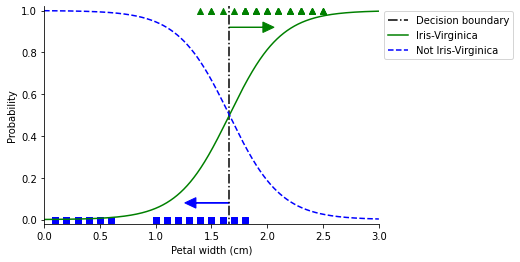

In [3]:
########################
# Fig 2.11
# Initially use 1 feature, 2 classes

x = iris["data"][:, 3:]  # petal width
y = (iris["target"] == 2).astype(jnp.int32)  # 1 if Iris-Virginica, else 0'

logistic_regression = LogisticRegression(solver="lbfgs", C=1)
logistic_regression.fit(x, y)

x_new = jnp.linspace(0, 3, 1000).reshape(-1, 1)
y_proba = logistic_regression.predict_proba(x_new)
decision_boundary = x_new[y_proba[:, 1] >= 0.5][0]

plt.figure()
plt.scatter(x[y == 0], y[y == 0], s=SCATTER_SIZE, c="b", marker="s")
plt.scatter(x[y == 1], y[y == 1], s=SCATTER_SIZE, c="g", marker="^")
plt.plot(
    [decision_boundary, decision_boundary],
    [-1, 2],
    color="black",
    linestyle="-.",
    label="Decision boundary",
)
plt.plot(x_new, y_proba[:, 1], "g-", label="Iris-Virginica")
plt.plot(x_new, y_proba[:, 0], "b--", label="Not Iris-Virginica")

plt.arrow(decision_boundary, 0.08, -0.3, 0, head_width=0.05, head_length=0.1, fc="b", ec="b")
plt.arrow(decision_boundary, 0.92, 0.3, 0, head_width=0.05, head_length=0.1, fc="g", ec="g")

plt.xlabel("Petal width (cm)")
plt.ylabel("Probability")
plt.legend(bbox_to_anchor=(1, 1))
plt.axis([0, 3, -0.02, 1.02])
sns.despine()
savefig("iris-logreg-1d_latexified.pdf")

In [4]:
def contour_loss(w0, w1, bias):
    test_parameters = {"weights": jnp.array([[w0], [w1]]), "bias": bias}
    return lr.binary_loss_function(test_parameters, train_x, train_y, 0.001)


def decision_boundary_plot(ax, weight0, weight1, parameters, train_x, train_y, fig_name=None):
    if is_latexify_enabled():
        ax.plot(train_x[train_y == 0, 0], train_x[train_y == 0, 1], "bs", markersize=1.5)
        ax.plot(train_x[train_y == 1, 0], train_x[train_y == 1, 1], "g^", markersize=1.5)
    else:
        ax.plot(train_x[train_y == 0, 0], train_x[train_y == 0, 1], "bs")
        ax.plot(train_x[train_y == 1, 0], train_x[train_y == 1, 1], "g^")

    # Predictions on test data
    # y_pred = logistic_regression.predict(test_x)

    # Plot decision boundary
    bounds_test_x0 = jnp.array([2.9, 7])
    decision_boundary = -(weight0 * bounds_test_x0 + parameters["bias"][0]) / weight1

    ax.plot(bounds_test_x0, decision_boundary, "k--", linewidth=1)
    ax.text(3.75, 1.70, "Not Iris-Virginica", color="b", ha="center")
    ax.text(6.5, 1.5, "Iris-Virginica", color="g", ha="center")
    ax.set_xlabel("Petal length (cm)")
    ax.set_ylabel("Petal width (cm)")
    ax.axis([2.9, 7, 0.8, 2.7])
    sns.despine()

    if fig_name:
        savefig(fig_name)

(150, 2)


/home/rohit_khoiwal/.local/lib/python3.8/site-packages/probml_utils/plotting.py:79: UserWarning: set FIG_DIR environment variable to save figures
  warnings.warn("set FIG_DIR environment variable to save figures")


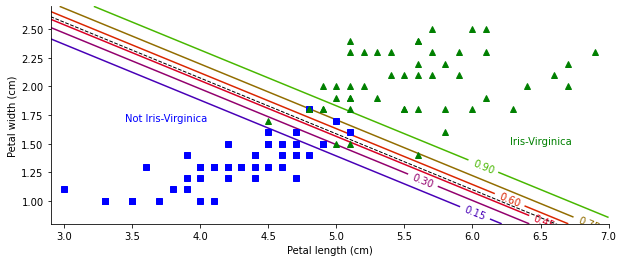

In [5]:
########################
# Now use 2 features, 2 classes

# Train Data
# petal length, petal width
train_x = iris["data"][:, (2, 3)]

# 1 if Iris-Virginica, else 0
train_y = (iris["target"] == 2).astype(jnp.int32)

print(train_x.shape)


# Fit model
parameters, losses = lr.fit(train_x, train_y)


# Test data

# # Generate values for petal length and petal width
test_featvec_x0, test_featvec_x1 = jnp.meshgrid(
    jnp.linspace(2.9, 7, 500),
    jnp.linspace(0.8, 2.7, 200),
)

# Plot data
if is_latexify_enabled():
    fig, ax = plt.subplots(1, 1)
else:
    fig, ax = plt.subplots(1, 1, figsize=(10, 4))

# Combine new values of petal length, petal width
test_x = jnp.c_[test_featvec_x0.ravel(), test_featvec_x1.ravel()]

# Predict probabilities
y_pred_proba = lr.predict_prob(parameters, test_x)

# Choose probability for label Iris-Virginica
prob_iris_virginca = y_pred_proba.reshape(test_featvec_x0.shape)
# Contour plot
contour = ax.contour(test_featvec_x0, test_featvec_x1, prob_iris_virginca, cmap=plt.cm.brg)

# Create decision boundary
bounds_test_x0 = jnp.array([2.9, 7])
decision_boundary = (
    -(parameters["weights"][0][0] * bounds_test_x0 + parameters["bias"][0]) / parameters["weights"][1][0]
)
ax.clabel(contour, inline=1)
decision_boundary_plot(
    ax,
    parameters["weights"][0][0],
    parameters["weights"][1][0],
    parameters,
    train_x,
    train_y,
    fig_name="iris-logreg-2d-2class",
)
sns.despine()
plt.show()

In [6]:
n = 100
weight0 = jnp.linspace(3, 6, n)
weight1 = jnp.linspace(7, 10, n)
grid_losses = jnp.zeros((n, n))
for i in range(n):
    for j in range(n):
        grid_losses = grid_losses.at[i, j].set(contour_loss(weight0[i], weight1[j], parameters["bias"][0]))
x, y = jnp.meshgrid(weight0, weight1)


def draw_plots(weight0, weight1, x, y, parameters, train_x, train_y):
    fig, ax = plt.subplots(1, 2, figsize=(15, 5), gridspec_kw={"width_ratios": [3, 2.3]})

    decision_boundary_plot(ax[0], weight0, weight1, parameters, train_x, train_y)

    # contour_poat
    CS = ax[1].contourf(x, y, grid_losses, alpha=0.7, cmap="viridis")
    ax[1].plot(weight0, weight1, marker="o", markersize=5, markeredgecolor="red", markerfacecolor="red")
    plt.contour(x, y, grid_losses, levels=50, linewidths=0.5, colors="black")
    props = dict(boxstyle="round", facecolor="white", alpha=0.5)
    loss = contour_loss(weight0, weight1, parameters["bias"][0])
    txt = f"Loss : %0.2f" % (loss)
    ax[1].text(0, 1.1, txt, verticalalignment="top", transform=ax[1].transAxes, bbox=props, fontsize=15)
    sns.despine()
    plt.colorbar(CS)
    plt.show()


w0 = FloatSlider(
    min=parameters["weights"][0][1] - 1.5,
    max=parameters["weights"][0][1] + 1.5,
    step=0.5,
    value=parameters["weights"][0][1],
)
w1 = FloatSlider(
    min=parameters["weights"][1][0] - 1.5,
    max=parameters["weights"][1][0] + 1.5,
    step=0.5,
    value=parameters["weights"][1][0],
)

interact(
    draw_plots,
    weight0=w0,
    weight1=w1,
    x=fixed(x),
    y=fixed(y),
    parameters=fixed(parameters),
    train_x=fixed(train_x),
    train_y=fixed(train_y),
)

interactive(children=(FloatSlider(value=4.374151229858398, description='weight0', max=5.874151229858398, min=2…

<function __main__.draw_plots(weight0, weight1, x, y, parameters, train_x, train_y)>

In [7]:
if is_latexify_enabled():
    latexify(width_scale_factor=2, fig_height=1.25, font_size=8)
    fig, ax = plt.subplots(1, 1)
    decision_boundary_plot(
        ax,
        parameters["weights"][0][0],
        parameters["weights"][1][0],
        parameters,
        train_x,
        train_y,
        fig_name="iris-logreg-2d-2class-no-probs",
    )
    latexify(width_scale_factor=1.1, fig_height=1.5)

/home/rohit_khoiwal/.local/lib/python3.8/site-packages/probml_utils/plotting.py:79: UserWarning: set FIG_DIR environment variable to save figures
  warnings.warn("set FIG_DIR environment variable to save figures")


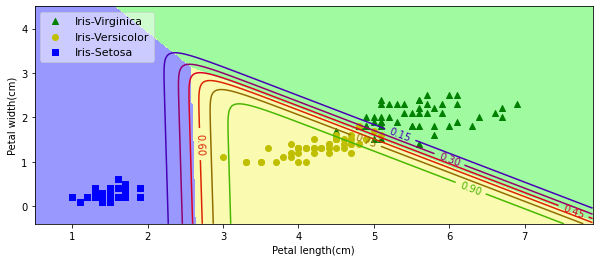

In [9]:
########################
# Now use 2 features and all 3 classes

# petal length, petal width
train_x = iris["data"][:, (2, 3)]
train_y = iris["target"]

# Fit model
softmax_reg = LogisticRegression(multi_class="multinomial", solver="lbfgs", C=10, random_state=42)
softmax_reg.fit(train_x, train_y)

# Generate values for petal length and petal width
test_featvec_x0, test_featvec_x1 = jnp.meshgrid(
    jnp.linspace(train_x[:, 0].min() - 0.5, train_x[:, 0].max() + 1, 500),
    jnp.linspace(train_x[:, 1].min() - 0.5, train_x[:, 1].max() + 2, 500),
)

plt.figure(figsize=(10, 4))

# Plot training data
plt.scatter(
    train_x[train_y == 2, 0],
    train_x[train_y == 2, 1],
    c="g",
    marker="^",
    zorder=2,
    label="Iris-Virginica",
)
plt.scatter(
    train_x[train_y == 1, 0],
    train_x[train_y == 1, 1],
    c="y",
    marker="o",
    zorder=2,
    label="Iris-Versicolor",
)
plt.scatter(
    train_x[train_y == 0, 0],
    train_x[train_y == 0, 1],
    c="b",
    marker="s",
    zorder=2,
    label="Iris-Setosa",
)


# Combine new values of petal length, petal width
test_x = jnp.c_[test_featvec_x0.ravel(), test_featvec_x1.ravel()]

# Predict probabilities
y_pred_proba = softmax_reg.predict_proba(test_x)

# Make predictions
y_predict = softmax_reg.predict(test_x)

# Choose probability for label Iris-Versicolor
prob_iris_versicolor = y_pred_proba[:, 1].reshape(test_featvec_x0.shape)
y_predict = y_predict.reshape(test_featvec_x0.shape)

custom_cmap = ListedColormap(["#9898ff", "#fafab0", "#a0faa0"])
plt.contourf(test_featvec_x0, test_featvec_x1, y_predict, cmap=custom_cmap)
contour = plt.contour(test_featvec_x0, test_featvec_x1, prob_iris_versicolor, cmap=plt.cm.brg)
clb = plt.clabel(contour, inline=1)

plt.xlabel("Petal length(cm)")
plt.ylabel("Petal width(cm)")
plt.legend(loc="upper left", framealpha=0.5, fontsize=11)
savefig("iris-logreg-2d-3class")
plt.show()

/home/rohit_khoiwal/.local/lib/python3.8/site-packages/probml_utils/plotting.py:26: UserWarning: LATEXIFY environment variable not set, not latexifying
  warnings.warn("LATEXIFY environment variable not set, not latexifying")


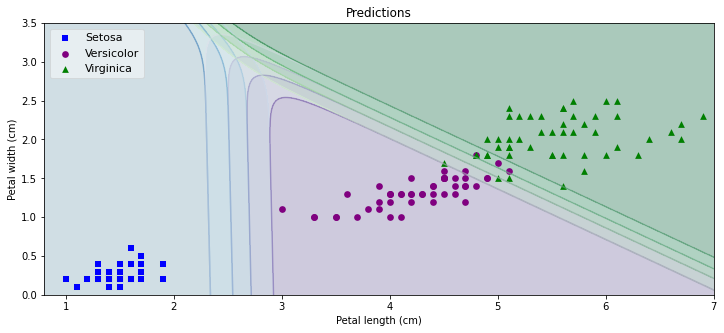

In [10]:
# Fig 2.13 - Use 2 features and all 3 classes

latexify(width_scale_factor=1.55)

# Intialize Plots and other options
if is_latexify_enabled():
    fig = plt.figure()
    SCATTER_SIZE = 10
    legend_fontsize = 5
    line_width = 0.8
else:
    fig = plt.figure(figsize=(12, 5))
    SCATTER_SIZE = 45
    legend_fontsize = 11
    line_width = 1.5

# Get axis of current plot
ax = plt.gca()

# Declare cmaps for countors
cmaps = ["Blues", "Purples", "Greens"]

# Store probabilities for each class
prob_iris_setosa = y_pred_proba[:, 0].reshape(test_featvec_x0.shape)
prob_iris_versicolor = y_pred_proba[:, 1].reshape(test_featvec_x0.shape)
prob_iris_virginica = y_pred_proba[:, 2].reshape(test_featvec_x0.shape)

# Plot countours
plt.contourf(
    test_featvec_x0,
    test_featvec_x1,
    prob_iris_setosa,
    cmap=cmaps[0],
    alpha=0.3,
    levels=[0.0, 0.2, 0.4, 0.6, 0.8, 1.0],
)

plt.contour(
    test_featvec_x0,
    test_featvec_x1,
    prob_iris_setosa,
    cmap=cmaps[0],
    alpha=0.4,
    linewidths=line_width,
    levels=[0.0, 0.2, 0.4, 0.6, 0.8, 1.0],
)

plt.contourf(
    test_featvec_x0,
    test_featvec_x1,
    prob_iris_versicolor,
    cmap=cmaps[1],
    alpha=0.3,
    levels=[0.0, 0.2, 0.4, 0.6, 0.8, 1.0],
)

plt.contour(
    test_featvec_x0,
    test_featvec_x1,
    prob_iris_versicolor,
    cmap=cmaps[1],
    alpha=0.4,
    linewidths=line_width,
    levels=[0.0, 0.2, 0.4, 0.6, 0.8, 1.0],
)

plt.contourf(
    test_featvec_x0,
    test_featvec_x1,
    prob_iris_virginica,
    cmap=cmaps[2],
    alpha=0.3,
    levels=[0.0, 0.2, 0.4, 0.6, 0.8, 1.0],
)

plt.contour(
    test_featvec_x0,
    test_featvec_x1,
    prob_iris_virginica,
    cmap=cmaps[2],
    alpha=0.4,
    linewidths=line_width,
    levels=[0.0, 0.2, 0.4, 0.6, 0.8, 1.0],
)

# Plot training data
plt.scatter(
    train_x[train_y == 0, 0],
    train_x[train_y == 0, 1],
    s=SCATTER_SIZE,
    c="blue",
    marker="s",
    edgecolor="black",
    linewidth=0.01,
    label="Setosa",
)

plt.scatter(
    train_x[train_y == 1, 0],
    train_x[train_y == 1, 1],
    s=SCATTER_SIZE,
    c="purple",
    marker="o",
    edgecolor="black",
    linewidth=0.01,
    label="Versicolor",
)

plt.scatter(
    train_x[train_y == 2, 0],
    train_x[train_y == 2, 1],
    s=SCATTER_SIZE,
    c="green",
    marker="^",
    edgecolor="black",
    linewidth=0.01,
    label="Virginica",
)

# Labels,title and legends for scatter plot
ax.set_xlabel("Petal length (cm)")
ax.set_ylabel("Petal width (cm)")
ax.set_title("Predictions")
ax.set_xlim([0.8, 7])
ax.set_ylim([0, 3.5])
ax.legend(loc="upper left", fontsize=legend_fontsize, framealpha=0.5)

savefig("iris_logreg_2d_latexified")

plt.show()

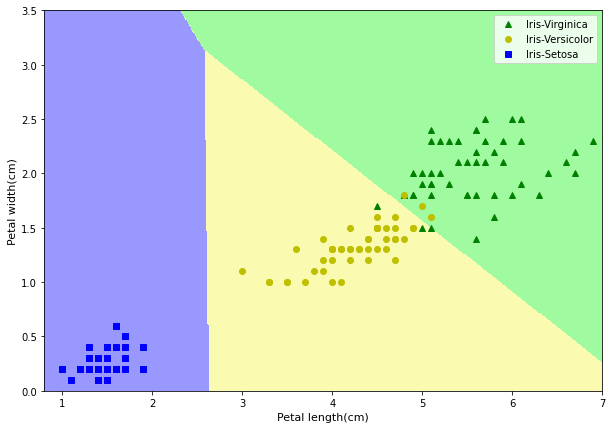

In [11]:
plt.figure(figsize=(10, 7))
plt.plot(train_x[train_y == 2, 0], train_x[train_y == 2, 1], "g^", label="Iris-Virginica")
plt.plot(train_x[train_y == 1, 0], train_x[train_y == 1, 1], "yo", label="Iris-Versicolor")
plt.plot(train_x[train_y == 0, 0], train_x[train_y == 0, 1], "bs", label="Iris-Setosa")

plt.contourf(test_featvec_x0, test_featvec_x1, y_predict, cmap=custom_cmap)
plt.xlabel("Petal length(cm)", fontsize=11)
plt.ylabel("Petal width(cm)", fontsize=11)
plt.legend(loc="upper right")
plt.axis([0.8, 7, 0, 3.5])
savefig("iris-logreg-2d-3class-noprobs")
plt.show()

In [12]:
########################
# Fit model and evaluate on separate test set

iris = datasets.load_iris()

# We only take the first two features to make problem harder
data_x = iris.data[:, :2]
data_y = iris.target

# Train Test split
x_train, x_test, y_train, y_test = train_test_split(data_x, data_y, test_size=0.33, random_state=42)

# Fit models
logreg = LogisticRegression(solver="lbfgs", multi_class="multinomial", C=1000)
logreg.fit(x_train, y_train)

# Make Predicitons
y_pred = logreg.predict(x_test)

# Calculate Errors
errs = y_pred != y_test
count_errs = jnp.sum(errs)
print("Made {} errors out of {}, on instances {}".format(count_errs, len(y_pred), jnp.where(errs)[0]))

# Zero One classification loss
err_rate_test = zero_one_loss(y_test, y_pred)
assert jnp.isclose(err_rate_test, count_errs / len(y_pred))
err_rate_train = zero_one_loss(y_train, logreg.predict(x_train))
print("Error rates on train {:0.3f} and test {:0.3f}".format(err_rate_train, err_rate_test))

Made 10 errors out of 50, on instances [ 4 15 21 32 35 36 40 41 42 48]
Error rates on train 0.180 and test 0.200
